<a href="https://colab.research.google.com/github/AditMeh/AditMeh.github.io/blob/master/Semantic%20Segmentation/Semantic_segmentation_drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPool2D, Add, Input, Conv2DTranspose, concatenate, BatchNormalization
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.activations import softmax


path = "/content/drive/MyDrive/resized_dataset"


def train_data_generator():
    images = os.listdir(os.path.join(path, "original_images"))[:200]
    for img in images:
    
        curr_img = cv2.imread(os.path.join(path, "original_images", img), 
                              cv2.IMREAD_UNCHANGED)

        curr_mask_folder = os.path.join(path, "masks", img.split(".")[0])
        
        # print([os.path.join(curr_mask_folder, mask) for mask in os.listdir(curr_mask_folder)])

        mask_list = [cv2.imread(os.path.join(curr_mask_folder, mask), cv2.IMREAD_GRAYSCALE)/255 
        for mask in os.listdir(curr_mask_folder)]

        anti_car_mask = np.where(mask_list[0][:, :] != 1.0, 1.0, 0)
        anti_person_mask = np.where(mask_list[1][:, :] != 1.0, 1.0, 0)

        new_mask = np.array((anti_person_mask == 1.0) & (anti_car_mask == 1.0), dtype=np.float32)
        mask_list.append(new_mask)

        probability_maps = np.dstack(mask_list)
        # print(np.unique(probability_maps))
        yield (tf.convert_to_tensor(curr_img, dtype="float"), tf.convert_to_tensor(probability_maps, dtype="float"))

train_data = tf.data.Dataset.from_generator(generator=train_data_generator,
                                            output_signature=(
                                            tf.TensorSpec(shape = (400, 400, 3), dtype = tf.float32),
                                            tf.TensorSpec(shape= (400, 400, 3), dtype=tf.float32))).batch(10, drop_remainder = False).repeat(10000)

0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


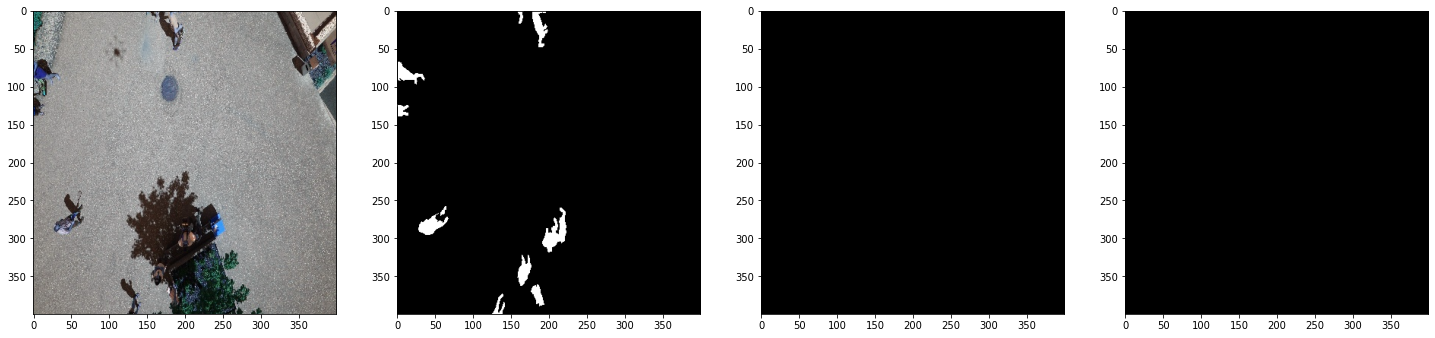

In [3]:
sample_image = os.path.join(os.path.join(path, "original_images"), "000.jpg")
sample_mask_person = os.path.join(os.path.join(path, "masks"), "000/15.png")
sample_mask_car = os.path.join(os.path.join(path, "masks"), "000/17.png")

image = cv2.imread(sample_image)
person_mask = cv2.imread(sample_mask_person, cv2.IMREAD_GRAYSCALE)
car_mask = cv2.imread(sample_mask_car, cv2.IMREAD_GRAYSCALE)
print(np.count_nonzero(car_mask))
print(car_mask)

person_mask = np.where(person_mask[:, :] == 128, 0, person_mask[:, :])



fig=plt.figure(figsize=(25, 25))
columns = 4
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(image)

fig.add_subplot(rows, columns, 2)
plt.imshow(person_mask, cmap="gray")

fig.add_subplot(rows, columns, 3)
plt.imshow(car_mask, cmap="gray")

anti_car_mask = np.where(car_mask[:, :] != 1.0, 1, 0)
anti_person_mask = np.where(person_mask[:, :] != 1.0, 1, 0)

new_mask = np.array((anti_person_mask == 1.0) & (anti_car_mask == 1.0), dtype=np.float32)
new_mask = np.where(new_mask[:, :] == 1.0, 255, 0)

fig.add_subplot(rows, columns, 4)
plt.imshow(new_mask, cmap="gray")


plt.show()

In [4]:
# Define model:

class ConvBlock(keras.layers.Layer):
    def __init__(self, filters, padding = "same"):
        super().__init__()

        self.conv1 = Conv2D(filters, kernel_size = (3,3),
                            padding = padding,
                            activation = "relu",
                            data_format = "channels_last",
                            kernel_initializer = "GlorotNormal")

        self.bn1 = BatchNormalization()

        self.conv2 = Conv2D(filters, kernel_size = (3,3),
                            padding = padding,
                            activation = "relu",
                            data_format = "channels_last",
                            kernel_initializer = "GlorotNormal")
        
        self.bn2 = BatchNormalization()
    def call(self, X):
        conv1 = self.conv1(X)
        conv1 = self.bn1(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.bn2(conv2)
        return conv2

def build_unet():
        inp = Input(shape = (400, 400, 3))


        # Downsampling path
        conv1 = ConvBlock(64, "same")(inp)

        pool1 = MaxPool2D(pool_size= (2,2))(conv1)

        conv2 = ConvBlock(128, "same")(pool1)

        pool2 = MaxPool2D(pool_size= (2,2))(conv2)

        conv3 = ConvBlock(256, "same")(pool2)

        pool3 = MaxPool2D(pool_size= (2,2))(conv3)

        conv4 = ConvBlock(512, "same")(pool3)

        pool4 = MaxPool2D(pool_size= (2,2))(conv4)

        conv5 = ConvBlock(1024, "same")(pool4)

        #Upsampling path

        upConv1 = Conv2DTranspose(filters=512, kernel_size=(2,2), strides=(2,2), padding = "same")(conv5)
        concat1 = concatenate([upConv1, conv4], axis=3)
        conv6 = ConvBlock(512)(concat1)

        upConv2 = Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding = "same")(conv6)
        concat2 = concatenate([upConv2, conv3], axis=3)
        conv7 = ConvBlock(256)(concat2)

        upConv3 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2), padding = "same")(conv7)
        concat3 = concatenate([upConv3, conv2], axis=3)
        conv8 = ConvBlock(64)(concat3)

        upConv4 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding = "same")(conv8)
        concat4 = concatenate([upConv4, conv1], axis=3)
        conv9 = ConvBlock(64)(concat4)

        conv10 = Conv2D(3, kernel_size = (3,3),
                        padding = "same",
                        activation = "softmax",
                        data_format = "channels_last",
                        kernel_initializer = "GlorotNormal")(conv9)
        
        #final = softmax(conv10, axis = 2)

        model = Model(inputs = inp, outputs = conv10)

        model.compile(optimizer = Adam(learning_rate = 0.01), loss = ['categorical_crossentropy'], metrics = ['accuracy'])

        return model

In [5]:
model = build_unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, 400, 400, 64) 39232       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 200, 200, 64) 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, 200, 200, 128 222464      max_pooling2d[0][0]              
______________________________________________________________________________________________

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=3, min_lr=1e-8)

history = model.fit(train_data, 
                    epochs = 50, steps_per_epoch = 10, callbacks=[reduce_lr])

Epoch 1/50
10/10 [==============================] - 21s 2s/step - loss: 0.3419 - accuracy: 0.9708
Epoch 2/50
10/10 [==============================] - 76s 8s/step - loss: 0.1480 - accuracy: 0.9757
Epoch 3/50
10/10 [==============================] - 15s 2s/step - loss: 0.1178 - accuracy: 0.9810
Epoch 4/50
10/10 [==============================] - 15s 2s/step - loss: 0.1208 - accuracy: 0.9739
Epoch 5/50
10/10 [==============================] - 15s 1s/step - loss: 0.0961 - accuracy: 0.9811
Epoch 6/50
10/10 [==============================] - 15s 1s/step - loss: 0.1144 - accuracy: 0.9754
Epoch 7/50
10/10 [==============================] - 15s 1s/step - loss: 0.0886 - accuracy: 0.9811
Epoch 8/50
10/10 [==============================] - 15s 1s/step - loss: 0.1033 - accuracy: 0.9755
Epoch 9/50
10/10 [==============================] - 15s 1s/step - loss: 0.0834 - accuracy: 0.9810
Epoch 10/50
10/10 [==============================] - 15s 1s/step - loss: 0.1019 - accuracy: 0.9754
Epoch 11/50
10/10 [

(400, 400, 3)


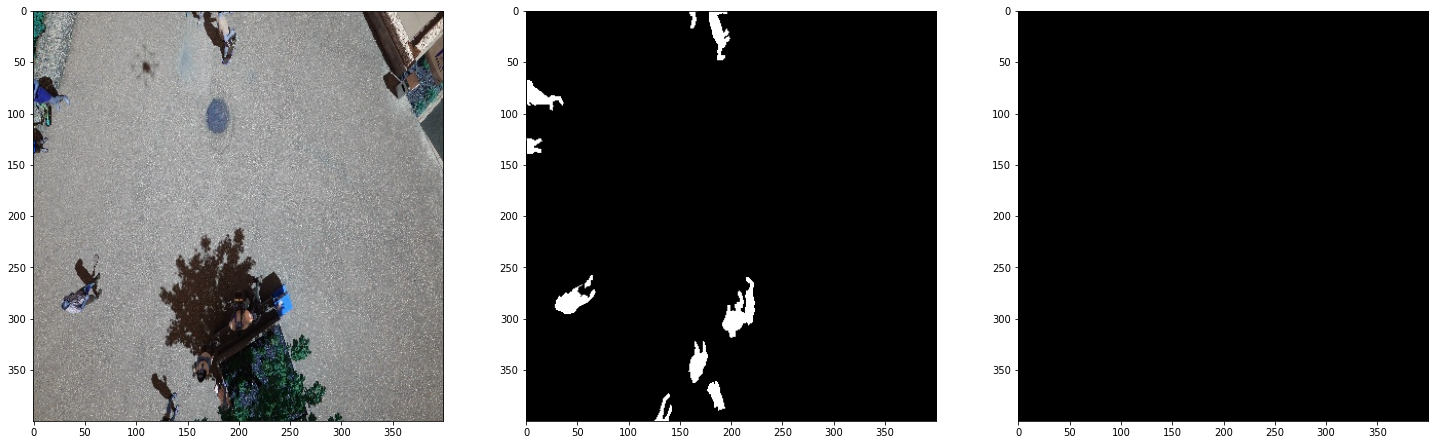

In [15]:
path = "/content/drive/MyDrive/resized_dataset"


temp = next(train_data.as_numpy_iterator())

person_pred_mask = np.where(np.squeeze(temp[1][:, :, 0]) == 1, 1, 0)

car_pred_mask = np.where(np.squeeze(temp[1][:, :, 1]) == 1, 1, 0)

image = temp[0][0]
print(image.shape)
#image = np.expand_dims(image, axis= 0)

# sample_image = os.path.join(os.path.join(path, "original_images"), "000.jpg")
# sample_mask_person = os.path.join(os.path.join(path, "masks"), "000/15.png")
# sample_mask_car = os.path.join(os.path.join(path, "masks"), "000/17.png")

# image = cv2.imread(sample_image)/255
# person_mask = cv2.imread(sample_mask_person)
# car_mask = cv2.imread(sample_mask_car)



fig=plt.figure(figsize=(25, 25))
columns = 3
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(np.squeeze(image).astype(np.uint8))

fig.add_subplot(rows, columns, 2)
plt.imshow(person_mask, cmap="gray")

fig.add_subplot(rows, columns, 3)
plt.imshow(car_mask, cmap="gray")


plt.show()

In [17]:
image = np.expand_dims(image, 0)
pred_image = model.predict(image)

print(np.unique(pred_image))
squeezed_maps = np.squeeze(pred_image)

print(squeezed_maps.shape)


person_pred_mask = np.where(squeezed_maps[:, :, 0] > 0.3, 255, 0)


car_pred_mask = np.where(squeezed_maps[:, :, 1] > 0.1, 255, 0)

background_pred_mask =  np.where(squeezed_maps[:, :, 2] > 0.1, 255, 0)

[2.5490393e-05 2.5493831e-05 2.5686555e-05 ... 9.9990845e-01 9.9990857e-01
 9.9990904e-01]
(400, 400, 3)


In [18]:
print(np.unique(car_pred_mask))
print(np.count_nonzero(car_pred_mask))
print(np.unique(person_pred_mask))
print(np.count_nonzero(person_pred_mask))
print(np.unique(background_pred_mask))
print(np.count_nonzero(background_pred_mask))

[  0 255]
7852
[  0 255]
192
[255]
160000


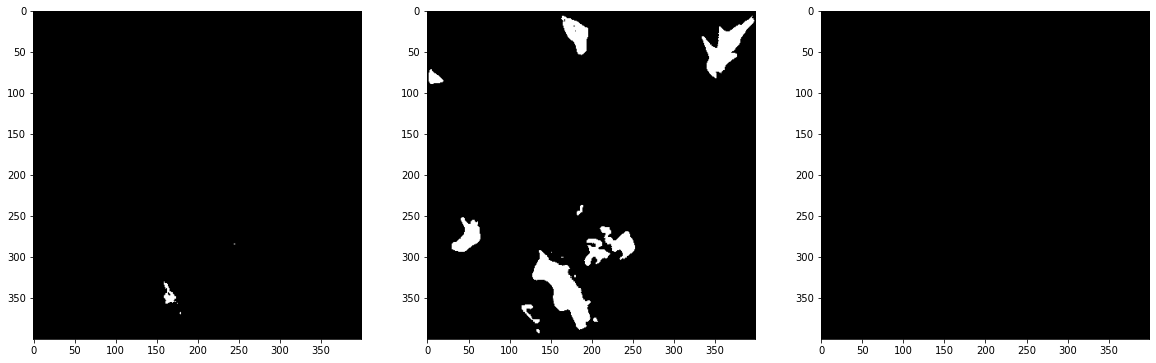

In [19]:
fig=plt.figure(figsize=(20, 20))
columns = 3
rows = 1


fig.add_subplot(rows, columns, 1)
plt.imshow(person_pred_mask, cmap="gray")

fig.add_subplot(rows, columns, 2)
plt.imshow(car_pred_mask, cmap="gray")

fig.add_subplot(rows, columns, 3)
plt.imshow(background_pred_mask, cmap="gray")

plt.show()